# Notebook to demonstrate processing workflow for OIB Alaska airborne radar data
Michael Christoffersen

First the raw data files from the digitizer need to be converted into HDF5 format files. The scripts to do this for different types of raw files are in the raw2h5 subdirectory.

# LoWRES Import and Processing

In [1]:
# Convert raw lowres data file to hdf5 - using example Malaspina data
!python ./raw2h5/lowres2h5.py /zippy/MARS/orig/supl/UAF/2019/20190928-235534.dat /zippy/MARS/targ/supl/UAF/2019/hdf5/
!h5ls -r /zippy/MARS/targ/supl/UAF/2019/hdf5/20190928-235534.h5

Traceback (most recent call last):
  File "./raw2h5/lowres2h5.py", line 72, in <module>
    main()
  File "./raw2h5/lowres2h5.py", line 59, in main
    dd = parseRaw(sys.argv[1])
  File "./raw2h5/lowres2h5.py", line 6, in parseRaw
    fd = open(fname, 'rb')
FileNotFoundError: [Errno 2] No such file or directory: '/zippy/MARS/orig/supl/UAF/2019/20190928-235534.dat'
/                        Group
/drv                     Group
/drv/clutter0            Dataset {5000, 27980}
/drv/pick                Group
/drv/pick/twtt_surf      Dataset {27980}
/drv/proc0               Dataset {5000, 27980}
/ext                     Group
/ext/nav0                Dataset {27980}
/ext/srf0                Dataset {27980}
/raw                     Group
/raw/loc0                Dataset {27980}
/raw/rx0                 Dataset {5000, 27980}
/raw/time0               Dataset {27980}
/raw/tx0                 Dataset {5000, 1}


HDF5 files are organized similar to a filesystem. They contain "datasets" and "groups" where datasets are analogous to files and groups are analogous to folders. The printout from h5ls above should show you that there are three groups in the root group ("/") of the file - drv, ext, and raw. The raw group holds the raw data from the lowres data file. The drv group is for products derived from data in the raw group. The ext group is for data dervied from external sources such as Chris Larsen's GPS navigation and lidar surface. The drv and ext groups are empty right now (with the exception of a pick subgroup in drv, which is there to hold any picks made in the data) but will be filled up later in the processing. The directory structure of the data processing folder mimics the structure of the HDF5 file. Scripts in the drv folder make products that go in the file's drv group and so on. Below this window is code to perform a more detailed printout of the file structure.

In [22]:
!h5ls -vr /zippy/MARS/targ/supl/UAF/2019/hdf5/20190928-235534.h5

Opened "/zippy/MARS/targ/supl/UAF/2019/hdf5/20190928-235534.h5" with sec2 driver.
/                        Group
    Attribute: Info scalar
        Type:      93-byte null-padded ASCII string
        Data:  "Data acquired by the University of Arizona Long Wavelength Radio Echo Sounder (LoWRES) system"
    Location:  1:96
    Links:     1
/drv                     Group
    Location:  1:1832
    Links:     1
/drv/clutter0            Dataset {5000/5000, 27980/27980}
    Location:  1:1291658409
    Links:     1
    Storage:   559600000 logical bytes, 559600000 allocated bytes, 100.00% utilization
    Type:      native float
/drv/pick                Group
    Location:  1:2536
    Links:     1
/drv/pick/twtt_surf      Dataset {27980/27980}
    Attribute: Source scalar
        Type:      17-byte null-padded ASCII string
        Data:  "OIB LIDAR+OIB GPS"
    Attribute: Unit scalar
        Type:      7-byte null-padded ASCII string
        Data:  "Seconds"
    Location:  1:1851262505
    Link

After the raw to HDF5 conversion most of the subsequent processing steps can go in any order. The only dependency may be clutter simulations waiting on improved navigation being written into ext from Chris Larsen's GPS, for example. I will do them in this order:
1. Pulse compress the data (this also includes a de-noising step)
2. Generate data quicklook image
3. Pull better navigation from Chris Larsen's navigation solutions
4. Generate map quicklook image
5. Pull a surface from Chris Larsen's lidar data
6. Perform surface clutter simulation

In [6]:
# Pulse compress the data
!python ./drv/pulseCompress.py /zippy/MARS/targ/supl/UAF/2019/hdf5/20190928-235534.h5
!h5ls -r /zippy/MARS/targ/supl/UAF/2019/hdf5/20190928-235534.h5

/                        Group
/drv                     Group
/drv/pick                Group
/drv/proc0               Dataset {5000, 27980}
/ext                     Group
/raw                     Group
/raw/loc0                Dataset {27980}
/raw/rx0                 Dataset {5000, 27980}
/raw/time0               Dataset {27980}
/raw/tx0                 Dataset {5000, 1}


The h5ls printout from the cell above shows that a new dataset has been added to the HDF5 file, /drv/proc0. This is the pulse compressed data. The quick look generator below will make a PNG.

In [2]:
# Generate quicklook image
!python ./qlook/dataQlook.py /zippy/MARS/targ/supl/UAF/2019/hdf5/20190928-235534.h5 /zippy/MARS/targ/supl/UAF/2019/qlook

The code below upens up the HDF5 file and displays the pulse compressed data in a manner similar to the quicklook

In [5]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter

f = h5py.File("/zippy/MARS/targ/supl/UAF/2019/hdf5/20190924-193525.h5","r")
pc = f["drv"]["proc0"][:]
srf = f["ext"]["srf0"][:]
nav = f["ext"]["nav0"][:]
f.close()

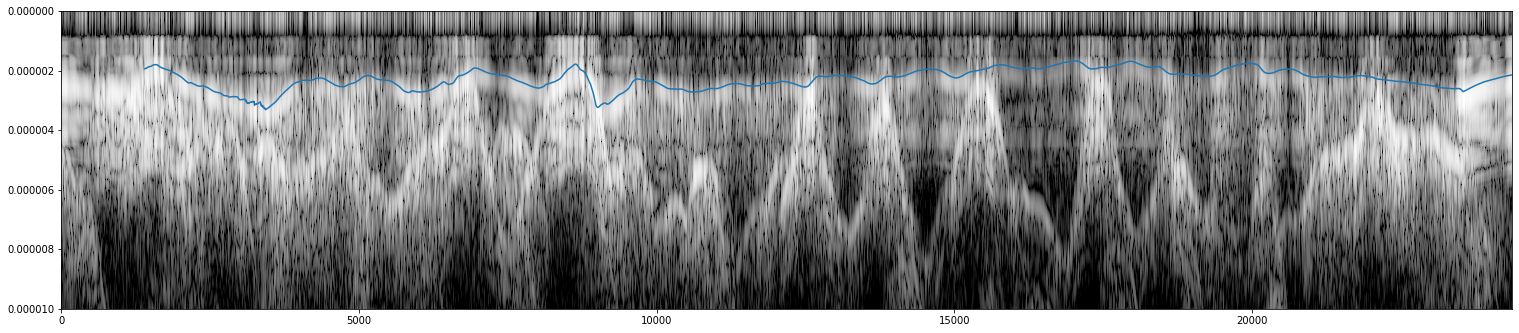

In [6]:
x = np.linspace(0, pc.shape[1]-1,pc.shape[1])
twtt = np.zeros(srf.shape)
for i in range(len(twtt)):
    twtt[i] = 2*(nav[i][2]-srf[i])/3e8
#twtt = 
#im = np.fft.fft(pc,axis=1)
#im = np.fft.fftshift(im,axes=1)
#frq = np.fft.fftfreq(im.shape[1],d=1/2000)
#print(frq)
im = np.log(np.abs(pc))
#pc = gaussian_filter(pc,1000)
#im = np.log(pc**2)
fig=plt.figure(figsize=(26, 16))
plt.imshow(im, aspect='5e8', cmap='Greys_r', vmin=.2*np.min(im), vmax=.9*np.max(im), extent=(0,pc.shape[1],10e-9*pc.shape[0],0))
plt.plot(x,twtt)
plt.ylim(10e-6,0)
plt.show()

# TDMS Import testing

In [19]:
!python ./raw2h5/tdms2h5.py /zippy/MARS/orig/supl/UAF/radar/2018/may/20180520-201202.tdms /zippy/MARS/targ/supl/UAF/2018/hdf5/
!h5ls -r /zippy/MARS/targ/supl/UAF/2018/hdf5/20180520-201202.h5

1526847122
/zippy/MARS/targ/supl/UAF/2018/hdf5//20180520-201202.h5
/                        Group
/drv                     Group
/drv/pick                Group
/ext                     Group
/raw                     Group
/raw/loc0                Dataset {232}
/raw/rx0                 Dataset {3237, 232}
/raw/time0               Dataset {232}
/raw/tx0                 Dataset {3237, 1}


In [20]:
!h5ls -rv /zippy/MARS/targ/supl/UAF/2018/hdf5/20180520-201202.h5

Opened "/zippy/MARS/targ/supl/UAF/2018/hdf5/20180523-222219.h5" with sec2 driver.
/                        Group
    Attribute: Info scalar
        Type:      103-byte null-padded ASCII string
        Data:  "Data acquired by the University of Texas Very Efficient Radar Very Efficient Team (VERVET) radar system"
    Location:  1:96
    Links:     1
/drv                     Group
    Location:  1:2032
    Links:     1
/drv/pick                Group
    Location:  1:2736
    Links:     1
/drv/proc0               Dataset {5000/5000, 5242/5242}
    Attribute: Notes scalar
        Type:      91-byte null-padded ASCII string
        Data:  "Mean removed in sliding 250 trace window : -105 sample circ shift to correct for xmit delay"
    Attribute: RefChirp scalar
        Type:      8-byte null-padded ASCII string
        Data:  "/raw/tx0"
    Location:  1:66167671
    Links:     1
    Chunks:    {79, 164} 103648 bytes
    Storage:   209680000 logical bytes, 178823078 allocated bytes, 117.26% 

In [ ]:
# Incorporate nav data

In [19]:
# Pulse compress the data
!python ./drv/pulseCompress.py /zippy/MARS/targ/supl/UAF/2018/hdf5/20180520-201202.h5
!h5ls -r /zippy/MARS/targ/supl/UAF/2018/hdf5/20180520-201202.h5

./drv/pulseCompress.py:79: RuntimeWarning: invalid value encountered in add
  mt = np.add(mt, np.divide(rx0[:,i], rx0.shape[1]))
./drv/pulseCompress.py:82: RuntimeWarning: invalid value encountered in subtract
  rx0NM[:,i] = rx0[:,i] - mt
/home/mchristo/.conda/envs/py3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
Figure(640x480)
/                        Group
/drv                     Group
/drv/pick                Group
/drv/proc0               Dataset {3237, 234}
/ext                     Group
/raw                     Group
/raw/loc0                Dataset {234}
/raw/rx0                 Dataset {3237, 234}
/raw/time0               Dataset {234}
/raw/tx0                 Dataset {3237, 1}


In [25]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter

f = h5py.File("/zippy/MARS/targ/supl/UAF/2018/hdf5/20180829-222655.h5","r")
#rx0 = f["raw"]["rx0"][:]
#pc = f["drv"]["proc0"][:]
nav = f["ext"]["nav0"][:]
loc = f["raw"]["loc0"][:]
f.close()

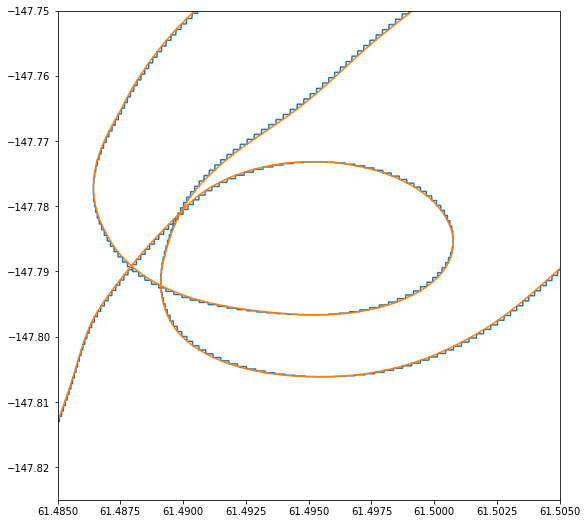

In [30]:
navlat = []
navlon = []
loclat = []
loclon = []

for i in range(len(nav)):
    navlat.append(nav[i][0])
    navlon.append(nav[i][1])
    loclat.append(loc[i][0])
    loclon.append(loc[i][1])
    
fig=plt.figure(figsize=(9, 9))
plt.plot(navlat,loclon, navlat, navlon)
plt.xlim([61.485, 61.505])
plt.ylim([-147.825, -147.750])
plt.show()

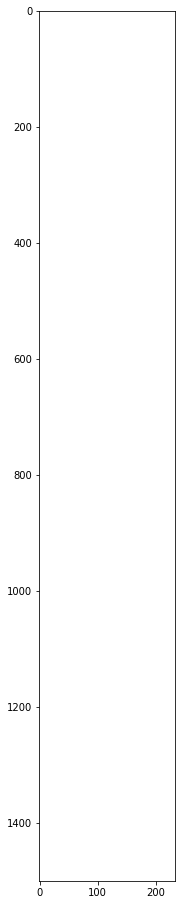

In [21]:
im = np.log(np.abs(pc))
fig=plt.figure(figsize=(26, 16))
plt.imshow(im, cmap='Greys_r', vmin=.2*np.min(im), vmax=np.max(im)) #extent=(0,pc.shape[1],10e-9*pc.shape[0],0))
plt.ylim(1500,0)
plt.show()

# Check if clutter is in 2019 files

Steps to run alaska clutter
1. Run dem subsetting program to create induvidual dems for all observations from big alaska dem
2. Run sums with hdf config and batch
3. Run addClutter

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter

f = h5py.File("/zippy/MARS/targ/supl/UAF/2019/hdf5/20190924-193525.h5","r")
clut = f["drv"]["clutter0"][:]
pc = f["drv"]["proc0"][:]
f.close()

/home/mchristo/.conda/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


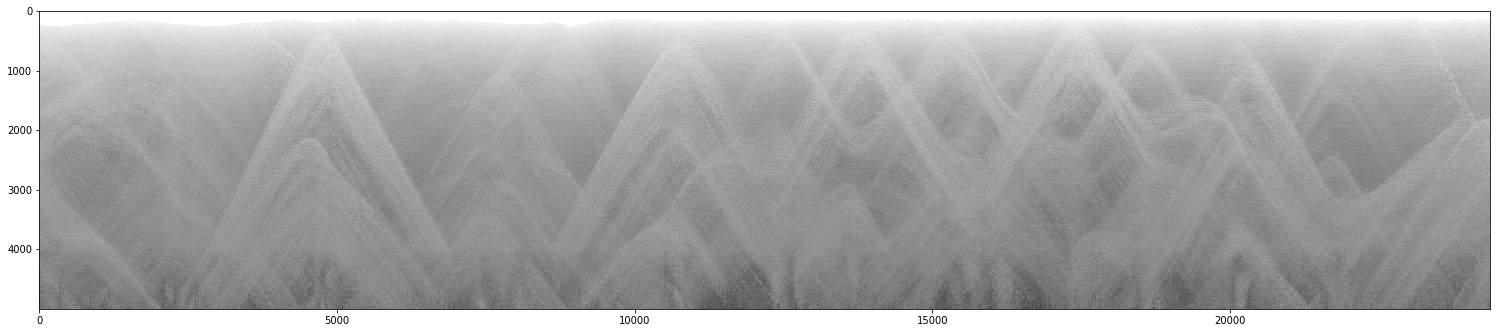

In [2]:
im = np.log(clut)
fig=plt.figure(figsize=(26, 16))
plt.imshow(im, cmap='Greys_r') #extent=(0,pc.shape[1],10e-9*pc.shape[0],0))
plt.show()

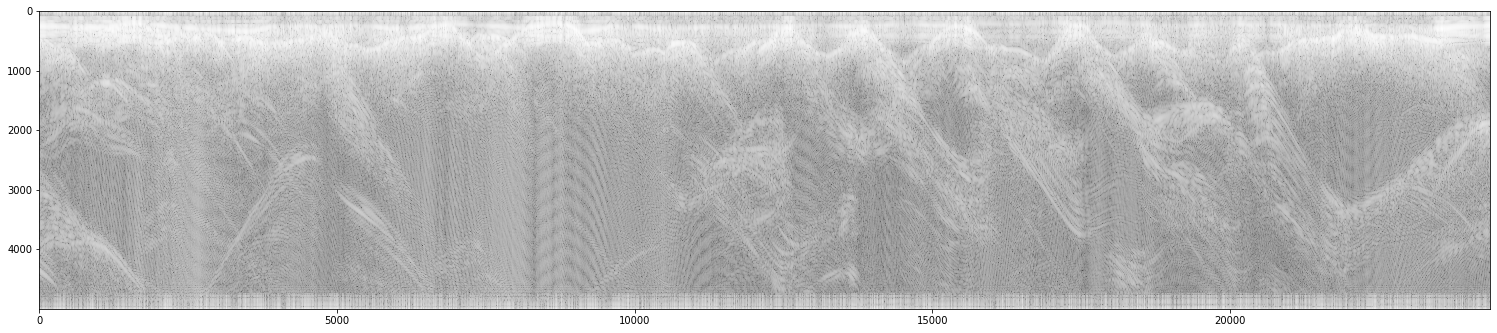

In [3]:
im = np.log(np.abs(pc))
fig=plt.figure(figsize=(26, 16))
plt.imshow(im, cmap='Greys_r') #extent=(0,pc.shape[1],10e-9*pc.shape[0],0))
plt.show()

# Test dumpNav.py

In [5]:
!python ./drv/dumpNav.py /zippy/MARS/targ/supl/UAF/2019/hdf5/20190924-193525.h5 /zippy/MARS/targ/supl/UAF/2019/clutterNav/
!head /zippy/MARS/targ/supl/UAF/2019/clutterNav/20190924-193525.csv

/zippy/MARS/targ/supl/UAF/2019/hdf5/20190924-193525.h5
61.12967,-147.04733,363.11676
61.12968,-147.04729,363.09174
61.12969,-147.04724,363.06775
61.1297,-147.0472,363.04276
61.12971,-147.04716,363.0172
61.12972,-147.04712,362.99274
61.12973,-147.04707,362.96875
61.12974,-147.04703,362.9442
61.12975,-147.047,362.92075
61.12976,-147.04695,362.89774
